In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.sparse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, make_scorer, f1_score, ConfusionMatrixDisplay
import os
import re

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Introduction

Below are data preprocessing performed already in EDA. We are preparing the data for modeling purposes. We would like to break down the process as following:

* Data preprocessing (basic data clean performed during EDA)

* Variable importance/ feature selection

* Principal component analysis

Since many drug prescription numbers can go up to thousands, it is best to scale the data and compare the model performance. We will assess whether scaling matters when the difference between min and max are in thousands.

* Train-Test Split

* Standard Scale

* MinMaxScaler

* MaxAbsScaler

After data preprocessing, 

* logistic regression (top 30 variables vs pca)

* SVM (top 30 variables vs pca)

* KNN (top 30 variables vs pca)

* Random Forest (top 30 variables vs pca)

* XGBoost (top 30 variables vs pca)


### Data preprocessing

Below preprocessing steps have already been performed in Exploratory Data Analysis. These steps were deemed to be best methods of choosing for building models after some exploration.

* Make drug names consistent across the board for data columns
* Exclude US territories but keep District of Columbia and 50 states
* Merge different ways to name specialties. Exclude "others" since specialty counts < 10 were deemd insignificant for not having enough sample sizes. Upon analysis of "others", it was a mixed bad and did not have much to interpret either.

In [2]:
# import data as csv files
df = pd.read_csv('prescriber-info.csv')
opioids = pd.read_csv('opioids.csv')

#List of drugnames overall
drug_names_overall = df.columns[5:-1]

# replace spaces and hypens with periods
opioids["Drug Name"] = opioids["Drug Name"].replace('-', '.', regex=True)
opioids["Drug Name"] = opioids["Drug Name"].replace(' ', '.', regex=True)

# Exclude US territories. Only include 50 states and DC
tables = pd.read_html(r'https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes') # get list of state abbreviations
states = tables[0]['Postal Code'] # 51 entries, including DC
df['State'] = np.where(df['State'].isin(states), df['State'], 'Other')
df = df[~df.State.str.contains('Other')] #include DC but exclude PR, VI, ZZ, AE, GU, AA # 24759 rows

# clean specialty values
df.loc[df['Specialty'].str.contains('Nurse'), 'Specialty'] = 'Nurse'
df.loc[df['Specialty'].str.contains('rectal', case=False), 'Specialty'] = 'Colorectal Surgery'
df.loc[df['Specialty'].str.contains('Physical'), 'Specialty'] = 'Physical Medicine'
df.loc[df['Specialty'].str.contains('Psychologist'), 'Specialty'] = 'Psychologist'
df.loc[df['Specialty'].str.contains('Pain'), 'Specialty'] = 'Pain Management'
df.loc[df['Specialty'].str.contains('Cardiac'), 'Specialty'] = 'Cardiology'
df.loc[df['Specialty'].str.contains('Oncology'), 'Specialty'] = 'Oncology'
df.loc[df['Specialty'].str.contains('Psychiatry', case=False), 'Specialty'] = 'Psychiatry'
df.loc[df['Specialty'].str.contains('Radiology'), 'Specialty'] = 'Radiology'
df.loc[df['Specialty'].str.contains('neuro', case=False), 'Specialty'] = 'Neurology'
df.loc[df['Specialty'].str.contains('Oral'), 'Specialty'] = 'Oral Surgery'
df.loc[df['Specialty'].str.contains('Radiology'), 'Specialty'] = 'Radiology'
df.loc[df['Specialty'].str.contains('Sports'), 'Specialty'] = 'Physical Medicine'
df['Specialty'] = df['Specialty'].replace(['Family Practice', 'Plastic and Reconstructive Surgery', 'Orthopaedic Surgery'], 
                                          ['Family Medicine', 'Plastic Surgery', 'Orthopedic Surgery'])
df.loc[df.groupby('Specialty').Specialty.transform('count').lt(10), 'Specialty'] = 'Other'
df = df[~df.Specialty.str.contains('Other')]
df.loc[df['Specialty'] == 'Student in an Organized Health Care Education/Training Program', 'Specialty'] \
= 'Medical Students, Interns, Residents'
#df['Specialty'].value_counts()

# Drop NPI (identification for each prescriber) and Credentials (since we will be using specialty instead)
df = df.drop(['NPI','Credentials'], axis = 1)
df = pd.get_dummies(df, columns = ['Gender','State','Specialty'])

In [3]:
X = df.copy()
X = X.drop(['Opioid.Prescriber'], axis = 1)
Y = df['Opioid.Prescriber']

In [4]:
X

,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,...,Specialty_Podiatry,Specialty_Preventive Medicine,Specialty_Psychiatry,Specialty_Pulmonary Disease,Specialty_Radiology,Specialty_Rheumatology,Specialty_Specialist,Specialty_Thoracic Surgery,Specialty_Urology,Specialty_Vascular Surgery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,134,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,43,0,0,0,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,19,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,12,0,0,0,46,25,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24996,0,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,0,0,0,0,0,0,16,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
# Check for sparsity of the data

scipy.sparse.issparse(X.values)


False

In [8]:
# Define the values to test for train_test_split
test_sizes = [0.2, 0.3, 0.5]

# Define the scaling techniques to test
scalers = [None, StandardScaler(), MinMaxScaler(), MaxAbsScaler()]

for test_size in test_sizes:
    
    for scaler in scalers:
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
        
        if scaler is None:
            X_train_scaled = X_train
            X_test_scaled = X_test
        else:
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.fit_transform(X_test)
        
        clf_rf = RandomForestClassifier(random_state = 0,oob_score=True)
        clf_rf = clf_rf.fit(X_train_scaled,Y_train)
        
        print("Test Size:", test_size)
        print("Scaler:", scaler if scaler is not None else "None")

        rf_accuracy_train = clf_rf.score(X_train_scaled,Y_train)
        rf_accuracy_test = clf_rf.score(X_test_scaled,Y_test)
        
        print("This is the training accuracy", rf_accuracy_train)
        print("This is the test accuracy", rf_accuracy_test)
        print("This is the OOB score",clf_rf.oob_score_)
        print("--------------------")

Test Size: 0.2
Scaler: None
This is the training accuracy 0.9986830775464721
This is the test accuracy 0.9167341977309562
This is the OOB score 0.9224028769690523
--------------------
Test Size: 0.2
Scaler: StandardScaler()
This is the training accuracy 0.9986830775464721
This is the test accuracy 0.9155186385737439
This is the OOB score 0.9224028769690523
--------------------
Test Size: 0.2
Scaler: MinMaxScaler()
This is the training accuracy 0.9986830775464721
This is the test accuracy 0.9161264181523501
This is the OOB score 0.9222002735146634
--------------------
Test Size: 0.2
Scaler: MaxAbsScaler()
This is the training accuracy 0.9986830775464721
This is the test accuracy 0.9161264181523501
This is the OOB score 0.9222002735146634
--------------------
Test Size: 0.3
Scaler: None
This is the training accuracy 0.9988422575976845
This is the test accuracy 0.9184224743381956
This is the OOB score 0.9227785817655572
--------------------
Test Size: 0.3
Scaler: StandardScaler()
This is 

Test Size of 0.3 with scalers MinMaxScaler() and MaxAbsScaler() came out to have the best results. Because the max value of all columns was in thousands and the minimum was zero, scaling did not have that much of an effect. This also explains why MaxAbs scaler and MinMax scaler yielded same results across the board.

* We will use test_size of 0.3 for now and test the performance of MinMaxScaler() with None and PCA in the future.

In [7]:
# In the future, we will use X_train, X_train_scaled (MinMaxScaler()), and X_pca (after we perform it)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train_scaled = MinMaxScaler().fit_transform(X_train)
X_test_scaled = MinMaxScaler().fit_transform(X_test)

### Hypertune RF to get the variable importance for the best performing RF

We will loop across number of trees and number of features to split on for building of random forest. The best performing combination will be chosen.

In [ ]:
# these model takes forever to run. Look at below list for results

rf_num_trees = np.arange(1,1101,50)

#400 is best - this model takes forever to run
store_error = list()
for n_tree in rf_num_trees:
    clf_rf = RandomForestClassifier(n_estimators = n_tree, random_state = 0)
    clf_rf = clf_rf.fit(X_train_scaled,Y_train)
    rf_accuracy = clf_rf.score(X_test_scaled,Y_test)
    store_error.append(1-rf_accuracy)
print(store_error)
#[0.1383036196650459, 0.08225283630470015, 0.0817125877903836, 0.08225283630470015, 0.0827930848190167, 0.08238789843327932, 0.08184764991896276, 0.08198271204754182, 0.0813074014046461, 0.08211777417612098, 0.08238789843327932, 0.08225283630470015, 0.08211777417612098, 0.08252296056185848, 0.08252296056185848, 0.08252296056185848, 0.0827930848190167, 0.08265802269043765, 0.08211777417612098, 0.08184764991896276, 0.08238789843327932, 0.08252296056185848]

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(rf_num_trees, store_error, label = 'Random Forest')
plt.legend()
plt.title('Test Error Comparision')
plt.xlabel('n_trees in Random Forest')
plt.ylabel('test error')

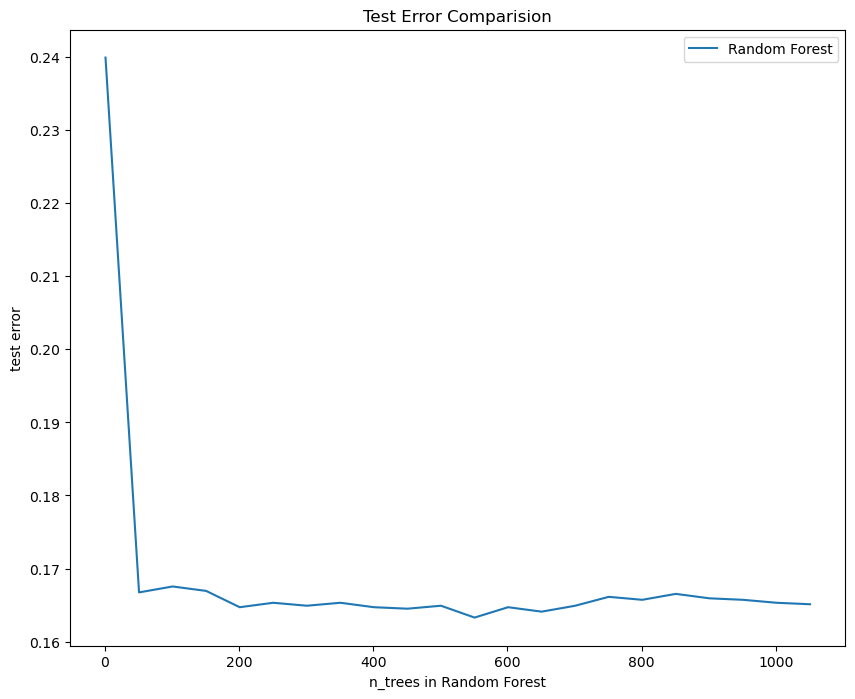

In [ ]:
#create lists for Test Error and OOB Error
store_errors_maxfeatures = list()
store_oob = list()

#Create tuning variable for parameter max_features
n_features_to_split = np.arange(0,X_train_scaled.shape[1]+1,15)[1:]
print(n_features_to_split)

In [ ]:
for n_features in n_features_to_split:
    clf_rf = RandomForestClassifier(n_estimators = 400, max_features=n_features,random_state = 0,oob_score=True)
    clf_rf = clf_rf.fit(X_train_scaled,Y_train)
    rf_accuracy = clf_rf.score(X_test_scaled,Y_test)
    store_errors_maxfeatures.append(1-rf_accuracy)
    store_oob.append(1- clf_rf.oob_score_)
print("model is finished")

In [ ]:
# print(len(store_oob))
# print(store_oob)
# print(len(store_errors_maxfeatures))
# print(store_errors_maxfeatures)

# #23
# #[0.07687409551374824, 0.07334298118668592, 0.0727062228654124, 0.0727062228654124, 0.0727062228654124, 0.0727062228654124, 0.07241678726483358, 0.0727062228654124, 0.0730535455861071, 0.0730535455861071, 0.07311143270622289, 0.07218523878437044, 0.07276410998552818, 0.0734008683068017, 0.07403762662807523, 0.07322720694645446, 0.0745007235890014, 0.07345875542691749, 0.07444283646888572, 0.07345875542691749, 0.0745007235890014, 0.07455861070911718, 0.07392185238784366]
# #23
# #[0.08306320907617504, 0.07887628309022154, 0.07766072393300916, 0.07739059967585094, 0.075634792004322, 0.07725553754727177, 0.07752566180442999, 0.07779578606158832, 0.0771204754186926, 0.07766072393300916, 0.07833603457590488, 0.07725553754727177, 0.07820097244732582, 0.07887628309022154, 0.07874122096164238, 0.07847109670448404, 0.07928146947595893, 0.07968665586169643, 0.07982171799027549, 0.08117233927606704, 0.08009184224743382, 0.07982171799027549, 0.08063209076175037]

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(n_features_to_split, store_errors_maxfeatures, label = 'RF Test Error')
ax.plot(n_features_to_split, store_oob, label = 'RF OOB Error')
plt.legend()
plt.title('Error Comparisions, max_features vs OOB & Test Errors')
plt.xlabel('n_features_to_split in Random Forest')
plt.ylabel('OOB/Test Errors')

#max features of 18 seems best

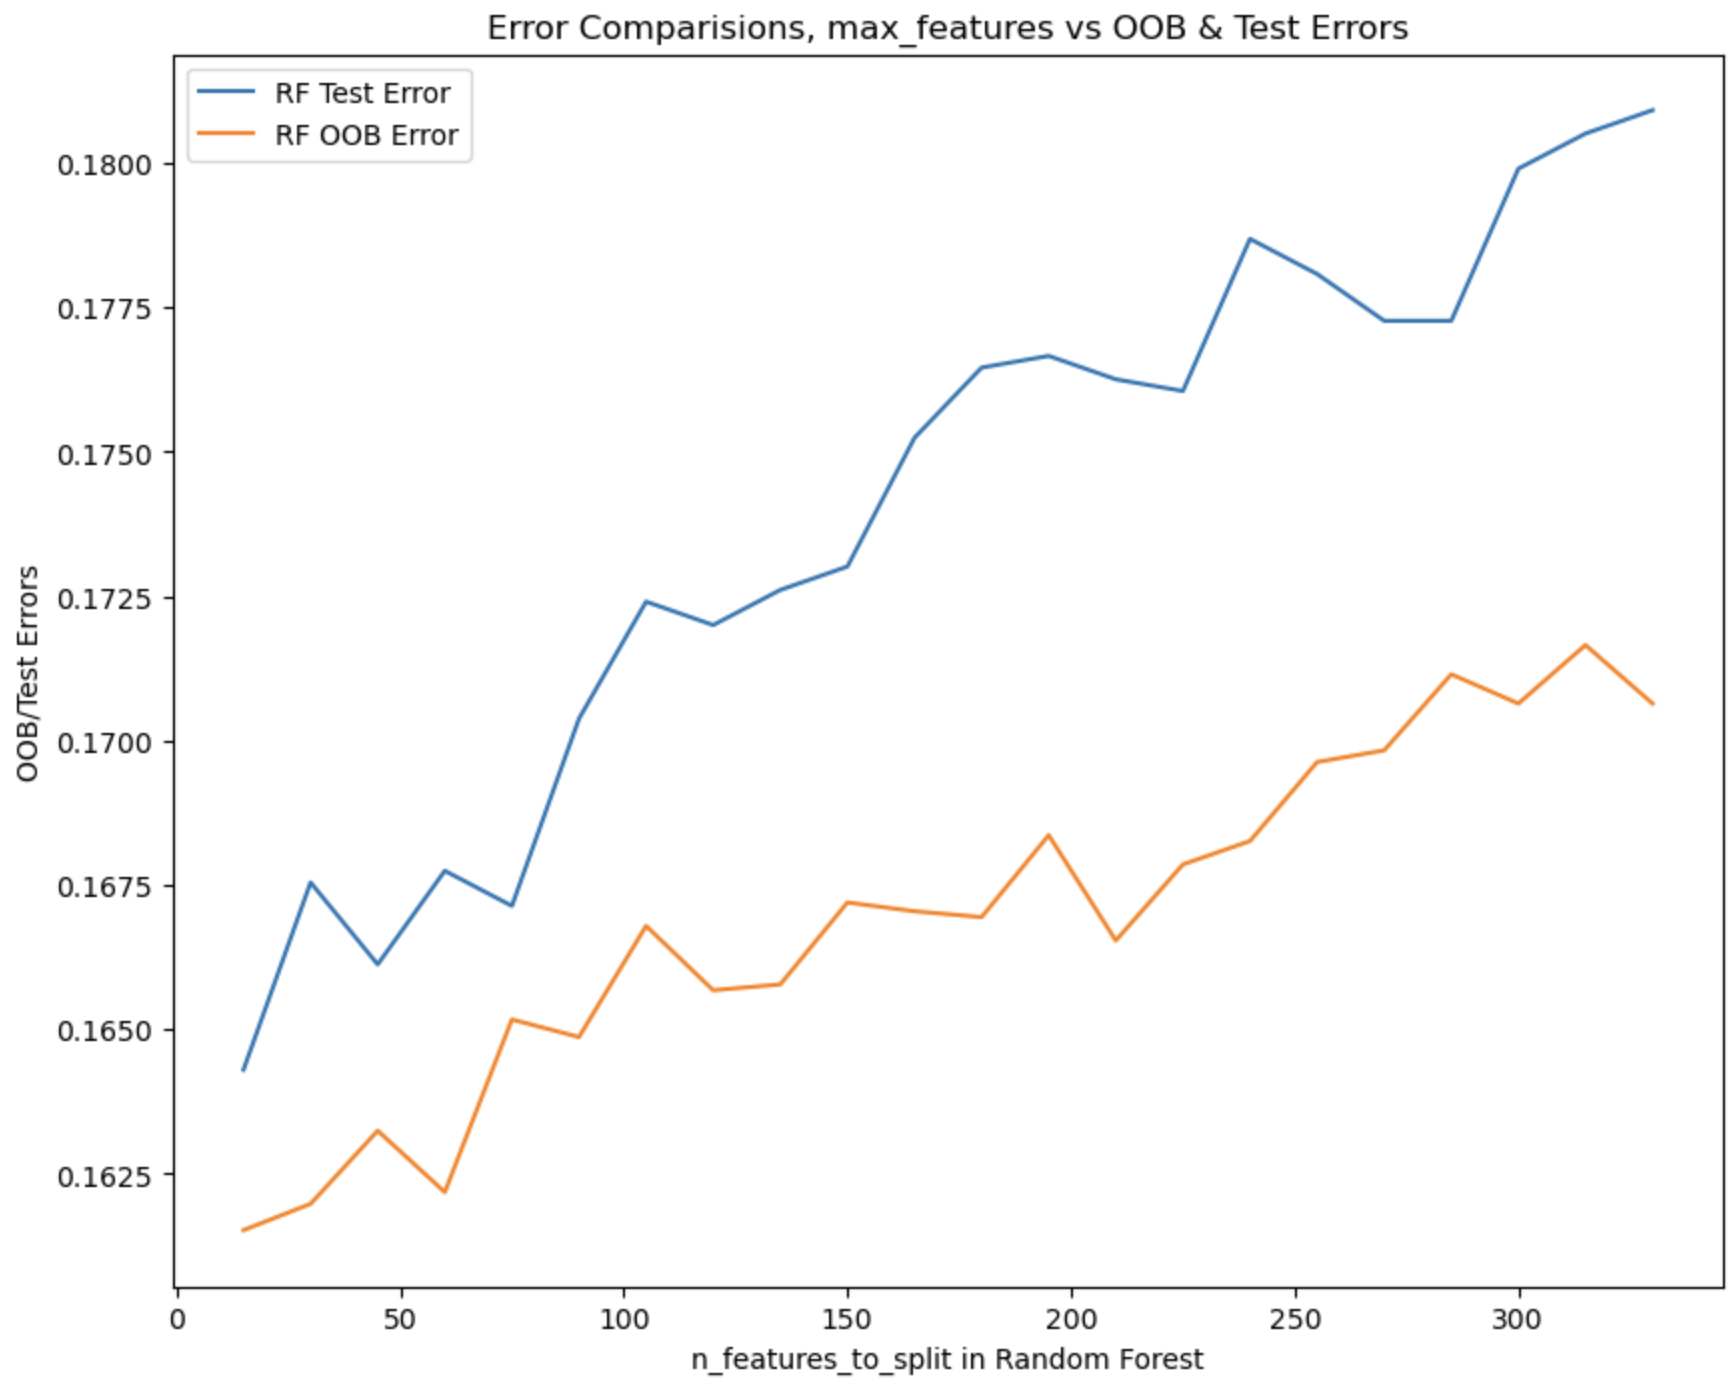

Looks like n_features_to_split of 18 and n_estimators of 400 will perform the best. We will choose 400 for now. 

### Variable Importance & Feature Selection

After buidling an optimized forest, we will analyze what features the model considers important and attempt to break it down.

In [8]:
# Perform optimized random forest to see which variables are important
clf_rf = RandomForestClassifier(n_estimators = 400, max_features=18,random_state = 0,oob_score=True)
clf_rf = clf_rf.fit(X_train_scaled,Y_train)
rf_accuracy = clf_rf.score(X_test_scaled,Y_test)
print(rf_accuracy)
print(clf_rf.oob_score_)

0.9203133441383036
0.9247467438494935


These are the important drugs in descending order [(0, 'HYDROCODONE.ACETAMINOPHEN'), (1, 'OXYCODONE.ACETAMINOPHEN'), (2, 'TRAMADOL.HCL'), (3, 'OXYCODONE.HCL'), (4, 'ACETAMINOPHEN.CODEINE')]


Text(0.5, 1.0, 'Top 30 Random Forest Feature Importance')

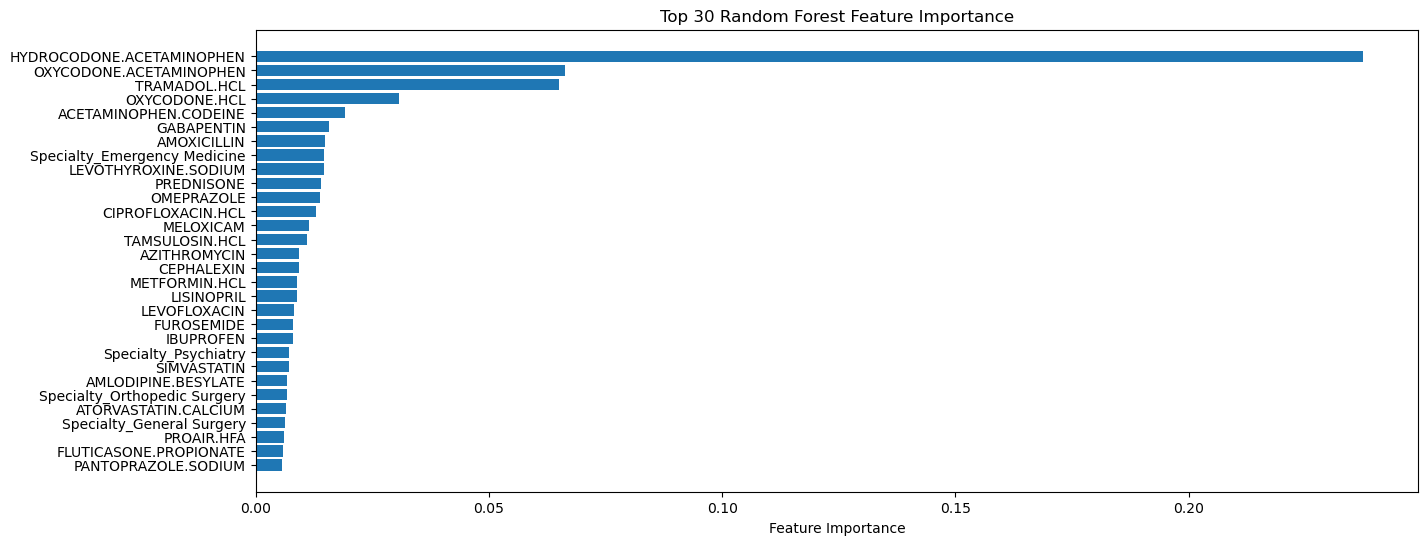

In [9]:
sort = clf_rf.feature_importances_.argsort()[-30:]
halfsort = clf_rf.feature_importances_.argsort()[-15:]
descending_order = list(X.columns[sort][::-1])

important_opioids = [(i, drug) for (i, drug) in enumerate(descending_order) if drug in set(opioids['Drug Name'])]
important_nonopioids_variables = [(i, var) for (i, var) in enumerate(descending_order) if var not in set(opioids['Drug Name'])]
print("These are the important drugs in descending order",important_opioids)

fig, ax = plt.subplots()
fig.set_size_inches( 15, 6)
plt.barh(X.columns[sort], clf_rf.feature_importances_[sort])
plt.xlabel("Feature Importance")
plt.title('Top 30 Random Forest Feature Importance')

In [10]:
# From opioids dataset, what are the intersections between that dataset and X columns?
opioids_varimp = set(opioids['Drug Name']) & set(X.columns[sort])

# What is the ratio between opioids and number of variables defined by sort?
ratio = len(set(opioids['Drug Name']) & set(X.columns[sort])) /len(set(X.columns[sort])) 

print("Out of Top 30 variables,", round(ratio,3), "of them are opioids.")
print("Out of Top 30 variables,", len(set(opioids['Drug Name']) & set(X.columns[sort])), "of them are opioids.")
print()
print("The opioids in the top 30 variables are:", important_opioids)
print()
print("When you discard 5 opioids from the 30 variables you get:", important_nonopioids_variables)

Out of Top 30 variables, 0.167 of them are opioids.
Out of Top 30 variables, 5 of them are opioids.

The opioids in the top 30 variables are: [(0, 'HYDROCODONE.ACETAMINOPHEN'), (1, 'OXYCODONE.ACETAMINOPHEN'), (2, 'TRAMADOL.HCL'), (3, 'OXYCODONE.HCL'), (4, 'ACETAMINOPHEN.CODEINE')]

When you discard 5 opioids from the 30 variables you get: [(5, 'GABAPENTIN'), (6, 'AMOXICILLIN'), (7, 'Specialty_Emergency Medicine'), (8, 'LEVOTHYROXINE.SODIUM'), (9, 'PREDNISONE'), (10, 'OMEPRAZOLE'), (11, 'CIPROFLOXACIN.HCL'), (12, 'MELOXICAM'), (13, 'TAMSULOSIN.HCL'), (14, 'AZITHROMYCIN'), (15, 'CEPHALEXIN'), (16, 'METFORMIN.HCL'), (17, 'LISINOPRIL'), (18, 'LEVOFLOXACIN'), (19, 'FUROSEMIDE'), (20, 'IBUPROFEN'), (21, 'Specialty_Psychiatry'), (22, 'SIMVASTATIN'), (23, 'AMLODIPINE.BESYLATE'), (24, 'Specialty_Orthopedic Surgery'), (25, 'ATORVASTATIN.CALCIUM'), (26, 'Specialty_General Surgery'), (27, 'PROAIR.HFA'), (28, 'FLUTICASONE.PROPIONATE'), (29, 'PANTOPRAZOLE.SODIUM')]


In [11]:
sorting_by_importance = clf_rf.feature_importances_.argsort()
all_imp_variables_desc = list(X.columns[sorting_by_importance][::-1])
all_imp_nonopioids = [var for var in all_imp_variables_desc if var not in set(opioids['Drug Name'])]

print("The top 15 variables when you take out opioids are:", all_imp_nonopioids[:15])
print()
important_specialty = [(i, specialty) for (i, specialty) in enumerate(all_imp_variables_desc) if specialty not in set(opioids['Drug Name']) and 'Specialty' in specialty]
print("Imporant speciaties are: ", important_specialty[:10])
print()
important_state = [(i, state) for (i, state) in enumerate(all_imp_variables_desc) if state not in set(opioids['Drug Name']) and 'State' in state]
print("Imporant speciaties are: ", important_state[:10])
print()
important_gender = [(i, gender) for (i, gender) in enumerate(all_imp_variables_desc) if gender not in set(opioids['Drug Name']) and 'Gender' in gender]
print("Imporant genders are: ", important_gender[:10])

The top 15 variables when you take out opioids are: ['GABAPENTIN', 'AMOXICILLIN', 'Specialty_Emergency Medicine', 'LEVOTHYROXINE.SODIUM', 'PREDNISONE', 'OMEPRAZOLE', 'CIPROFLOXACIN.HCL', 'MELOXICAM', 'TAMSULOSIN.HCL', 'AZITHROMYCIN', 'CEPHALEXIN', 'METFORMIN.HCL', 'LISINOPRIL', 'LEVOFLOXACIN', 'FUROSEMIDE']

Imporant speciaties are:  [(7, 'Specialty_Emergency Medicine'), (21, 'Specialty_Psychiatry'), (24, 'Specialty_Orthopedic Surgery'), (26, 'Specialty_General Surgery'), (41, 'Specialty_Oncology'), (50, 'Specialty_Optometry'), (56, 'Specialty_Family Medicine'), (64, 'Specialty_Internal Medicine'), (69, 'Specialty_Physician Assistant'), (74, 'Specialty_Nurse')]

Imporant speciaties are:  [(47, 'State_NY'), (66, 'State_FL'), (67, 'State_CA'), (79, 'State_PA'), (81, 'State_TX'), (85, 'State_MI'), (97, 'State_MD'), (98, 'State_NJ'), (102, 'State_OH'), (109, 'State_IL')]

Imporant genders are:  [(49, 'Gender_F'), (52, 'Gender_M')]


Run random forest without opioids and see what variables are important

In [17]:
# Remove opioids from this particular dataset and see varimp
opioids_to_remove = list(set(opioids['Drug Name']) & set(df.columns.tolist()))
X_varimp = df.copy()
X_varimp = X_varimp[X_varimp.columns.difference(opioids_to_remove)]
X_varimp = X_varimp.drop(['Opioid.Prescriber'], axis = 1)
Y_varimp = df['Opioid.Prescriber']


X_train_imp, X_test_imp, Y_train_imp, Y_test_imp = train_test_split(X_varimp, Y_varimp, test_size=0.3, random_state=42)    
X_train_scaled_imp = MinMaxScaler().fit_transform(X_train_imp)
X_test_scaled_imp = MinMaxScaler().fit_transform(X_test_imp)

clf_rf = RandomForestClassifier(n_estimators = 400, max_features=18,random_state = 0,oob_score=True)
clf_rf = clf_rf.fit(X_train_scaled_imp,Y_train_imp)
rf_accuracy = clf_rf.score(X_test_scaled_imp,Y_test_imp)
print(rf_accuracy)
print(clf_rf.oob_score_)

0.833063209076175
0.8369898697539797


Text(0.5, 1.0, 'Top 30 Random Forest Feature Importance without Opioids')

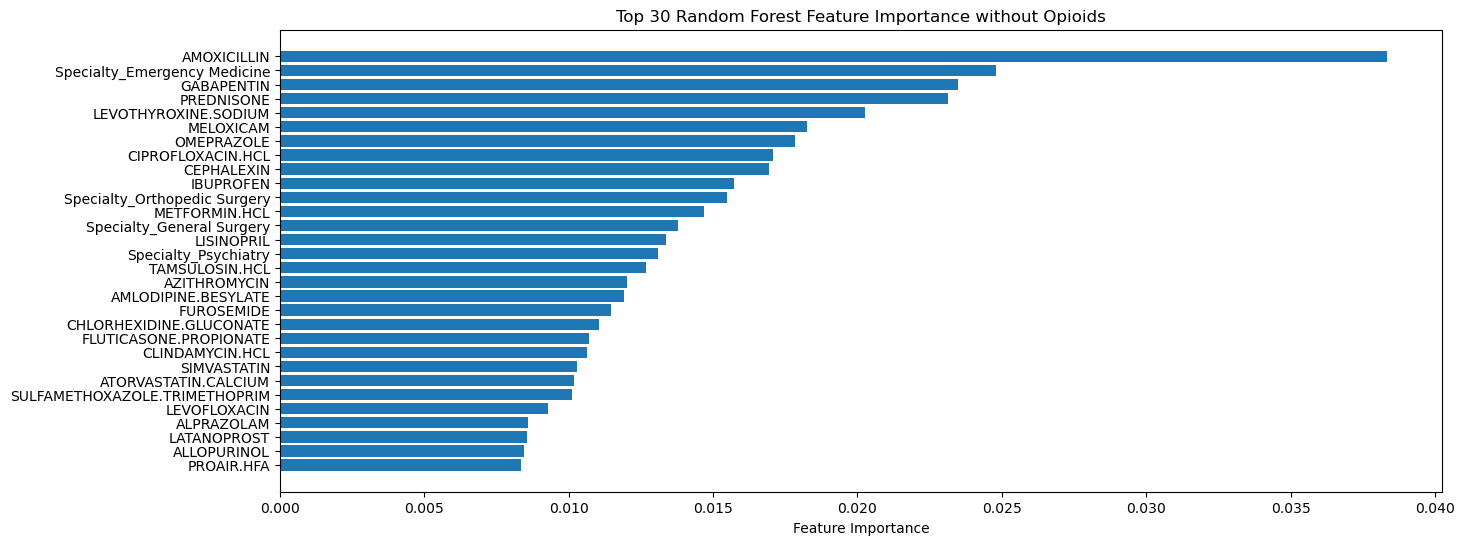

In [13]:
sort = clf_rf.feature_importances_.argsort()[-30:]
halfsort = clf_rf.feature_importances_.argsort()[-15:]
descending_order = list(X_varimp.columns[sort][::-1])


fig, ax = plt.subplots()
fig.set_size_inches( 15, 6)
plt.barh(X_varimp.columns[sort], clf_rf.feature_importances_[sort])
plt.xlabel("Feature Importance")
plt.title('Top 30 Random Forest Feature Importance without Opioids')



In [14]:
sorting_by_importance = clf_rf.feature_importances_.argsort()
all_imp_variables_desc = list(X_varimp.columns[sorting_by_importance][::-1])


print("The top 15 variables when you take out opioids are:", all_imp_variables_desc[:15])
print()
important_nonopioids_variables = [(i, var) for (i, var) in enumerate(descending_order) if var in drug_names_overall]
print("These are the important variables in descending order",important_nonopioids_variables[:10])
print()
important_specialty = [(i, specialty) for (i, specialty) in enumerate(all_imp_variables_desc) if specialty not in set(opioids['Drug Name']) and 'Specialty' in specialty]
print("Imporant speciaties are: ", important_specialty[:10])
print()
important_state = [(i, state) for (i, state) in enumerate(all_imp_variables_desc) if state not in set(opioids['Drug Name']) and 'State' in state]
print("Imporant speciaties are: ", important_state[:10])
print()
important_gender = [(i, gender) for (i, gender) in enumerate(all_imp_variables_desc) if gender not in set(opioids['Drug Name']) and 'Gender' in gender]
print("Imporant genders are: ", important_gender[:10])

The top 15 variables when you take out opioids are: ['AMOXICILLIN', 'Specialty_Emergency Medicine', 'GABAPENTIN', 'PREDNISONE', 'LEVOTHYROXINE.SODIUM', 'MELOXICAM', 'OMEPRAZOLE', 'CIPROFLOXACIN.HCL', 'CEPHALEXIN', 'IBUPROFEN', 'Specialty_Orthopedic Surgery', 'METFORMIN.HCL', 'Specialty_General Surgery', 'LISINOPRIL', 'Specialty_Psychiatry']

These are the important variables in descending order [(0, 'AMOXICILLIN'), (2, 'GABAPENTIN'), (3, 'PREDNISONE'), (4, 'LEVOTHYROXINE.SODIUM'), (5, 'MELOXICAM'), (6, 'OMEPRAZOLE'), (7, 'CIPROFLOXACIN.HCL'), (8, 'CEPHALEXIN'), (9, 'IBUPROFEN'), (11, 'METFORMIN.HCL')]

Imporant speciaties are:  [(1, 'Specialty_Emergency Medicine'), (10, 'Specialty_Orthopedic Surgery'), (12, 'Specialty_General Surgery'), (14, 'Specialty_Psychiatry'), (34, 'Specialty_Physician Assistant'), (38, 'Specialty_Optometry'), (46, 'Specialty_Oncology'), (47, 'Specialty_Dentist'), (69, 'Specialty_Internal Medicine'), (70, 'Specialty_Nurse')]

Imporant speciaties are:  [(40, 'Stat

In [18]:
#below is the feature reduced dataset that includes top 30 most important variables - excluding opioids, Opioid.Prescriber
X_top30_variables = X_varimp[X_varimp.columns[sort]]
Y_top30_variables = df['Opioid.Prescriber']

X_train_30, X_test_30, Y_train_30, Y_test_30 = train_test_split(X_top30_variables, Y_top30_variables, test_size=0.3, random_state=42)    
X_train_scaled_30 = MinMaxScaler().fit_transform(X_train_30)
X_test_scaled_30 = MinMaxScaler().fit_transform(X_test_30)



### Principal Component Analysis

Run PCA for dimensionality reduction (prep them for running models) and Get inklings about Var Imp

177 is the total number of components to retain 85% of variance
(17275, 177)
(7404, 177)


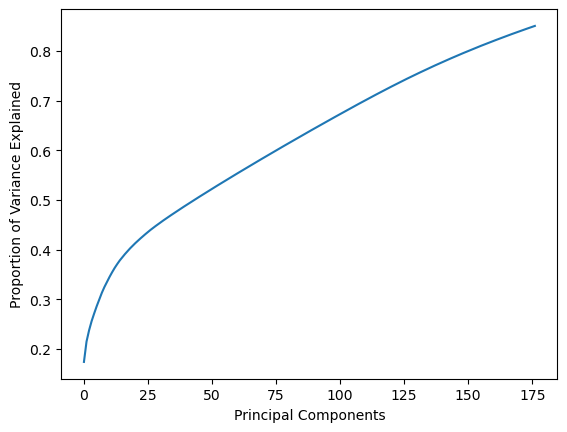

In [19]:
#PCA for exploratory analysis and picking important variables using PCA

df_PCA = df.copy()
opioids_to_remove = list(set(opioids['Drug Name']) & set(df.columns.tolist()))
X_PCA = X.copy()
X_PCA = X_PCA[X_PCA.columns.difference(opioids_to_remove)]
Y_PCA = Y.copy()

X_train_PCA, X_test_PCA, Y_train_PCA, Y_test_PCA = train_test_split(X_PCA, Y_PCA, test_size=0.3, random_state=42)

# Scale already split data for PCA analysis
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train_PCA)

# Apply transform to both the training set and the test set.
X_train_PCA = scaler.transform(X_train_PCA)
X_test_PCA = scaler.transform(X_test_PCA)

# Make an instance of the Model 
pca = PCA(n_components=0.85) #needs 177 components to retain 85% of variance
#fit PCA on training set
pca.fit(X_train_PCA)

variance = pca.explained_variance_ratio_

print(pca.n_components_, "is the total number of components to retain 85% of variance")

plt.plot(np.cumsum(variance))
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variance Explained')


X_train_pca = pca.transform(X_train_PCA) ### USE THIS
X_test_pca = pca.transform(X_test_PCA) ### USE THIS

print(X_train_pca.shape)
print(X_test_pca.shape)

As opposed to the 30 varibles that we used for PCA, Random Forest was only able to reduce the number of components down to 177 to retain 85% of variability. We would have to test how PCA data compared with the data with 30 variables.

## Logistic Regression

Our first model is logistic regression, which we will be running on scaled data, 30 variables data, and PCA data.

In [24]:
# base model - MaxMinScaler data without opioids - X_train_scaled_imp, X_test_scaled_imp, Y_train_imp, Y_test_imp
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

logreg = LogisticRegressionCV(cv=None, scoring='f1', max_iter=10000, random_state=42)
logreg.fit(X_train_scaled_imp, Y_train_imp)


Y_pred_logreg_base = logreg.predict(X_test_scaled_imp)
acc_logr = round(accuracy_score(Y_test_imp, Y_pred_logreg_base), 3)
pr_logr = round(precision_score(Y_test_imp, Y_pred_logreg_base), 3)
recall_logr = round(recall_score(Y_test_imp, Y_pred_logreg_base), 3)
f1_logr = round(f1_score(Y_test_imp, Y_pred_logreg_base), 3)
auc_logr = round(roc_auc_score(Y_test_imp, Y_pred_logreg_base),3)

print(acc_logr, pr_logr, recall_logr, f1_logr, auc_logr)


# regular (cv=None): 0.806 0.838 0.825 0.832 0.802
# 5-fold (cv=5): 0.806 0.838 0.825 0.832 0.802
# 10-fold (cv=10): 0.806 0.838 0.825 0.831 0.802

0.806 0.838 0.825 0.832 0.802


For the base model, cv=5 and None perform the best across the board. For best practice, we will choose cv=5.

In [27]:
# 30 variables model - MaxMinScaler data without opioids - X_train_scaled_30, X_test_scaled_30, Y_train_30, Y_test_30
logreg = LogisticRegressionCV(cv=10, scoring='f1', max_iter=10000, random_state=42)
logreg.fit(X_train_scaled_30, Y_train_30)


Y_pred_logreg_30 = logreg.predict(X_test_scaled_30)
acc_logr = round(accuracy_score(Y_test_30, Y_pred_logreg_base), 3)
pr_logr = round(precision_score(Y_test_30, Y_pred_logreg_base), 3)
recall_logr = round(recall_score(Y_test_30, Y_pred_logreg_base), 3)
f1_logr = round(f1_score(Y_test_30, Y_pred_logreg_base), 3)
auc_logr = round(roc_auc_score(Y_test_30, Y_pred_logreg_base),3)

print(acc_logr, pr_logr, recall_logr, f1_logr, auc_logr)


# regular (cv=None): 0.777 0.847 0.753 0.797 0.782
# 5-fold (cv=5): 0.777 0.847 0.753 0.797 0.782
# 10-fold (cv=10): 0.777 0.847 0.753 0.797 0.782

0.777 0.847 0.753 0.797 0.782


In [30]:
# PCA model - Standard Scaler data without opioids - X_train_pca, X_test_pca, Y_train_PCA, Y_test_PCA
logreg = LogisticRegressionCV(cv=5, scoring='f1', max_iter=10000, random_state=42)
logreg.fit(X_train_pca, Y_train_PCA)


Y_pred_logreg_pca = logreg.predict(X_test_pca)
acc_logr = round(accuracy_score(Y_test_PCA, Y_pred_logreg_base), 3)
pr_logr = round(precision_score(Y_test_PCA, Y_pred_logreg_base), 3)
recall_logr = round(recall_score(Y_test_PCA, Y_pred_logreg_base), 3)
f1_logr = round(f1_score(Y_test_PCA, Y_pred_logreg_base), 3)
auc_logr = round(roc_auc_score(Y_test_PCA, Y_pred_logreg_base),3)

print(acc_logr, pr_logr, recall_logr, f1_logr, auc_logr)


# regular (cv=None): 0.804 0.842 0.817 0.829 0.802
# 5-fold (cv=5): 0.804 0.842 0.817 0.829 0.802
# 10-fold (cv=10): 0.804 0.842 0.817 0.829 0.802

0.804 0.842 0.817 0.829 0.802


Best performing results for accuracy, precision, recall, F1, AUC:
* Base: 0.806 0.838 0.825 0.832 0.802
* 30 Variables: 0.777 0.847 0.753 0.797 0.782
* PCA: 0.804 0.842 0.817 0.829 0.802

Base model took the longest to run, and 30 Variables model was the fastest to run. PCA model did not take long and performed comparably with the Base model. 

## SVM

Our second model is support vector machine, which we will be running on scaled data, 30 variables data, and PCA data.

In [ ]:
# base model - MaxMinScaler data without opioids - X_train_scaled_imp, X_test_scaled_imp, Y_train_imp, Y_test_imp
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#param_grid = {'C': [1e-6,1e-3,0.1,1, 10, 1e3,1e6], 'gamma': [1000,10,1,0.1,0.001,1e-6],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid = {'C': [1, 10, 50, 100, 500, 1e3,1e6], 'gamma': [0.1,1,10,100,1000],'kernel': ['rbf']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_scaled_imp,Y_train_imp)
Y_pred_svm_base = grid.predict(X_test_scaled_imp)

#Check accuracy, precision, recall, f1, auc
print(grid.best_score_)
print(grid.best_params_)
pr_svm_base = round(precision_score(Y_test_imp, Y_pred_svm_base), 3)
recall_svm_base = round(recall_score(Y_test_imp, Y_pred_svm_base), 3)
f1_svm_base = round(f1_score(Y_test_imp, Y_pred_svm_base), 3)
auc_svm_base = round(roc_auc_score(Y_test_imp, Y_pred_svm_base),3)

print(grid.best_score_, pr_svm_base, recall_svm_base,f1_svm_base,auc_svm_base)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  22.6s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  22.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  22.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  22.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  22.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  27.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  27.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  26.9s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  27.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  26.8s
[CV] END ..........................C=1, gamma=10, kernel=rbf; total time= 1.5min
[CV] END ..........................C=1, gamma=1

In [ ]:
grid.best_params_


In [ ]:
# 30 variables model - MaxMinScaler data without opioids - X_train_scaled_30, X_test_scaled_30, Y_train_30, Y_test_30

#param_grid = {'C': [1e-6,1e-3,0.1,1, 10, 1e3,1e6], 'gamma': [1000,10,1,0.1,0.001,1e-6],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid = {'C': [1, 10, 50, 100, 500, 1e3,1e6], 'gamma': [0.1,1,10,100,1000],'kernel': ['rbf']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_scaled_30,Y_train_30)
Y_pred_svm_30 = grid.predict(X_test_scaled_30)

#Check accuracy, precision, recall, f1, auc
print(grid.best_score_)
print(grid.best_params_)
pr_svm_30 = round(precision_score(Y_test_30, Y_pred_svm_30), 3)
recall_svm_30 = round(recall_score(Y_test_30, Y_pred_svm_30), 3)
f1_svm_30 = round(f1_score(Y_test_30, Y_pred_svm_30), 3)
auc_svm_30 = round(roc_auc_score(Y_test_30, Y_pred_svm_30),3)

print(grid.best_score_, pr_svm_30, recall_svm_30,f1_svm_30,auc_svm_30)

In [ ]:
# PCA model - Standard Scaler data without opioids - X_train_pca, X_test_pca, Y_train_PCA, Y_test_PCA
#param_grid = {'C': [1e-6,1e-3,0.1,1, 10, 1e3,1e6], 'gamma': [1000,10,1,0.1,0.001,1e-6],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid = {'C': [1, 10, 50, 100, 500, 1e3,1e6], 'gamma': [0.1,1,10,100,1000],'kernel': ['rbf']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_pca,Y_train_PCA)
Y_pred_svm_pca = grid.predict(X_test_pca)

#Check accuracy, precision, recall, f1, auc
print(grid.best_score_)
print(grid.best_params_)
pr_svm_pca = round(precision_score(Y_test_PCA, Y_pred_svm_pca), 3)
recall_svm_pca = round(recall_score(Y_test_PCA, Y_pred_svm_pca), 3)
f1_svm_pca = round(f1_score(Y_test_PCA, Y_pred_svm_pca), 3)
auc_svm_pca = round(roc_auc_score(Y_test_PCA, Y_pred_svm_pca),3)

print(grid.best_score_, pr_svm_pca, recall_svm_pca,f1_svm_pca,auc_svm_pca)

## K-Nearest Neighbors

## Random Forest

## XGBoost

In [ ]:
#1e-3
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#param_grid = {'C': [1e-6,1e-3,0.1,1, 10, 1e3,1e6], 'gamma': [1000,10,1,0.1,0.001,1e-6],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid = {'C': [1e-3], 'gamma': np.logspace(-3,2,6),'kernel': ['linear','rbf', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_pca,Y_train)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
#1e-2
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#param_grid = {'C': [1e-6,1e-3,0.1,1, 10, 1e3,1e6], 'gamma': [1000,10,1,0.1,0.001,1e-6],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid = {'C': [1e-2], 'gamma': np.logspace(-3,2,6),'kernel': ['linear','rbf', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_pca,Y_train)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
#1e-1
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#param_grid = {'C': [1e-6,1e-3,0.1,1, 10, 1e3,1e6], 'gamma': [1000,10,1,0.1,0.001,1e-6],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid = {'C': [1e-1], 'gamma': np.logspace(-3,2,6),'kernel': ['linear','rbf', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_pca,Y_train)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
#1e0
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#param_grid = {'C': [1e-6,1e-3,0.1,1, 10, 1e3,1e6], 'gamma': [1000,10,1,0.1,0.001,1e-6],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid = {'C': [1e0], 'gamma': np.logspace(-3,2,6),'kernel': ['linear','rbf', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_pca,Y_train)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
#1e1
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#param_grid = {'C': [1e-6,1e-3,0.1,1, 10, 1e3,1e6], 'gamma': [1000,10,1,0.1,0.001,1e-6],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid = {'C': [1e1], 'gamma': np.logspace(-3,2,6),'kernel': ['linear','rbf', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_pca,Y_train)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
#1e2
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#param_grid = {'C': [1e-6,1e-3,0.1,1, 10, 1e3,1e6], 'gamma': [1000,10,1,0.1,0.001,1e-6],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid = {'C': [1e2], 'gamma': np.logspace(-3,2,6),'kernel': ['linear','rbf', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_pca,Y_train)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
print(grid.best_score_)

In [ ]:
# {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
# 0.7424023154848045

# {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
# 0.7658465991316932

# {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
# 0.7990159189580318

# {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
# 0.8309696092619392

# {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
# 0.8394211287988422

## belowis the best
# {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
# 0.8420839363241679


In [ ]:
#1e2
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#param_grid = {'C': [1e-6,1e-3,0.1,1, 10, 1e3,1e6], 'gamma': [1000,10,1,0.1,0.001,1e-6],'kernel': ['rbf', 'poly', 'sigmoid']}
param_grid = {'C': [50,60,70,80,90,100,110], 'gamma': [0.1],'kernel': ['rbf']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_pca,Y_train)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
#find the best performing parameter and test it for var Imp also for svm
param_grid = {'C': [50], 'gamma': [0.1] ,'kernel': ['rbf'] }
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_pca,Y_train)



In [ ]:
Y_pred_svm_pca = grid.predict(X_test_pca)


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

pr_svm_pca = round(precision_score(Y_test, Y_pred_svm_pca), 3)
recall_svm_pca = round(recall_score(Y_test, Y_pred_svm_pca), 3)
f1_svm_pca = round(f1_score(Y_test, Y_pred_svm_pca), 3)
auc_svm_pca = round(roc_auc_score(Y_test, Y_pred_svm_pca),3)

print(pr_svm_pca, recall_svm_pca,f1_svm_pca,auc_svm_pca)

In [ ]:
#maxabs_imp 30 0.844 0.786 0.814 0.792




In [ ]:
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
pca.explained_variance_ratio_

In [ ]:
df_PCA = df.drop(['NPI','Credentials'], axis = 1)
df_PCA = pd.get_dummies(df_PCA, columns = ['Gender','State','Specialty'])
X_PCA = df_PCA.copy()
X_PCA = X_PCA.drop(['Opioid.Prescriber'], axis = 1)
Y_PCA = df_PCA['Opioid.Prescriber']
X = X_PCA.values

scale_X = StandardScaler().fit_transform(X)
pca = PCA(n_components=20)

#principalComponents is the data with PC0...PC19
principalComponents = pca.fit_transform(scale_X)
print(principalComponents.shape)
var= pca.explained_variance_ratio_
print(var)

In [ ]:
import numpy as np
np.logspace(-3,2,6)